# 1 Constructing the matrix X

In [1]:
# imports
import numpy as np
import scipy as scp
from scipy.sparse import coo_matrix
import scipy.sparse.linalg as linalg
import scipy.io
import matplotlib.pylab as plt

In [2]:
def construct_X(M, alphas, Np = None, s0 = None, a0 = None, b0 = None):
    # convert to radians
    alphas = np.array(alphas)*np.pi*180**-1
    
    # number of pixels sensor
    if Np == None:
        Np = np.round(2**0.5*M)
        if Np%2 != 0:
            Np = Np+1

    if s0 == None:
        s0 = (Np-1)/2
        
    if a0 == None:
        a0 = -0.5*M
        
    if b0 == None:
        b0 = -0.5*M
      
    # number of orientations
    No = len(alphas)
    
    # center coordinates of pixel
    Jba = np.mgrid[:M,:M]
    C = np.array([Jba[1].ravel()+a0,Jba[0].ravel()+b0])
    
    # unit vector of orientation
    n = np.array([np.sin(alphas),np.cos(alphas)])
    
    # projection
    p = np.matmul(n.T,C) + s0
    
    # only use p when on the detector
    cond = np.array([np.logical_and(p>0,p<Np),np.logical_and(p>-1,p<Np-1)]).ravel()
    
    # indices
    Npio = Np*np.mgrid[:M**2,:No][1].T
    i_indices = np.array([p.astype(int)+Npio,np.round(p+0.5).astype(int)+Npio]).ravel() *cond
    #j_indices = np.array([np.arange(M**2) for i in range(2*No)]).ravel()*cond
    j_indices = np.array([Jba[1]+M*Jba[0]]*2*No).ravel()*cond
        
    # compute weights
    w1 = np.abs(p-p.astype(int))
    w2 = 1 - w1
    weights = np.array([w2,w1]).ravel()*cond

    # generate X matrix
    X = coo_matrix((weights, (i_indices, j_indices)), shape=(int(Np*No), int(M**2)), dtype = np.float32)
    
    return X

(-0.5, 99.5, 44.5, -0.5)

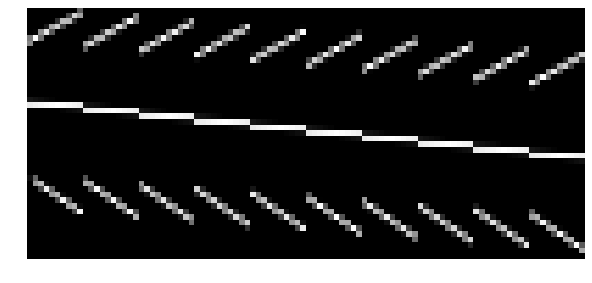

In [3]:
# test matrix generation
X = construct_X(10,np.array([-33,1,42,]),15).toarray()

plt.figure(figsize=[10,15])
plt.imshow(X,cmap='gray')
plt.axis('off')

(-0.5, 99.5, 44.5, -0.5)

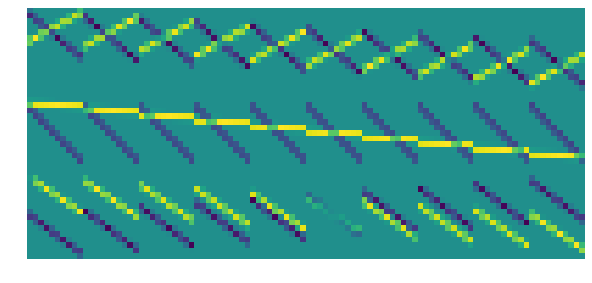

In [4]:
# load example and plot difference
X_ex = np.load('hs_tomography/X_example.npy')

plt.figure(figsize=[10,15])
plt.imshow(X-X_ex)
plt.axis('off')

0
-180.0
err1 183.51448
-165.0
-150.0
-135.0
-120.0
-105.0
err1 183.50304
err1 183.49002
err1 183.45047
err1 183.43842
err1 183.42766
-90.0
err1 183.39001
err1 183.38829
-75.0
-60.0
-45.0
-30.0
-15.0
0.0
15.0
30.0
45.0
60.0
75.0
err1 182.22147
err1 147.25885
90.0
err1 140.64728
err1 122.16351
err1 68.9435
err1 0.0
105.0
120.0
135.0
150.0
165.0
180.0
1 90.0 7.0 -4.5 -4.5 0.0


(-0.5, 99.5, 44.5, -0.5)

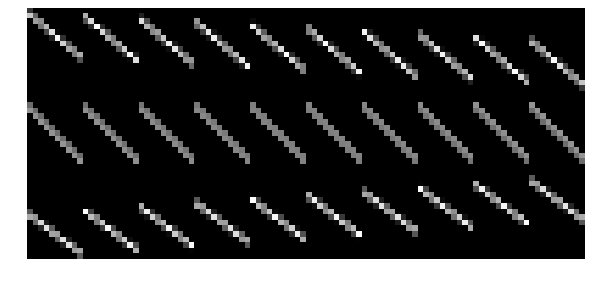

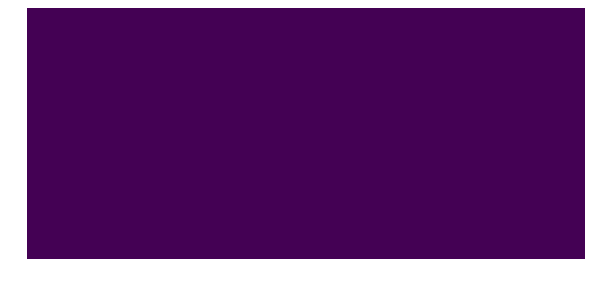

In [5]:
# minimize the squared error to find angle

# perform hill climb
err0 = 1e4
err = 1e4
al0 = 0
a0 = 0
b0 = 0
s0 = 0
Al = np.linspace(-180,180,25)
S = np.linspace(-14,14,9)
A = np.linspace(-9,9,13)
B = np.linspace(-9,9,13)
n = 0

while err0 > 0.1 and (err - err0)==0:# or n < 2:
    
    err = err0
 
    if n ==0:
        Al1 = Al+al0
        S1 = S+s0
        A1 = A+a0
        B1 = B+b0
        
    elif n%4==0:
        Al1 = 0.04**np.int(n/4)*Al+al0
    elif n%4==1:
        S1 = 0.1**np.int(n/4)*S+s0
    elif n%4==2:
        A1 = 0.1**np.int(n/4)*A+a0
    elif n%4==3:
        B1 = 0.1**np.int(n/4)*B+b0

    
    print(n)
    n = n+1
    
    for al1 in Al1:
        print(al1)
        for s1 in S1:
            for a1 in A1:
                for b1 in B1:
                    X = construct_X(10,np.array([-33,1,42])+al1,15,s1,a1,b1).toarray()
                    err1 = np.sum(np.square(np.subtract(X_ex,X)))

                    if err1 < err0:
                        print('err1',err1)
                        al0 = al1
                        a0 = a1
                        b0 = b1
                        err0 = err1
                        s0 = s1

print(n,al0,s0,a0,b0,err0)    
X = construct_X(10,np.array([-33,1,42])+al0,15,s0,a0,b0).toarray()

plt.figure(figsize=[10,15])
plt.imshow(X,cmap='gray')
plt.axis('off')

plt.figure(figsize=[10,15])
plt.imshow(X-X_ex)
plt.axis('off')

The parameters can be found in the following way:
    $$ \alpha_0 = 90 \mathrm{\ deg} $$
    $$ s_0 = (N_p-1)/2 $$
    $$ a_0, b_0 = (M-1)/2 $$

# 2 Recovering the image

In [6]:
# read in data
alphas_195 = scp.load('hs_tomography/alphas_195.npy')
alphas_77 = scp.load('hs_tomography/alphas_77.npy')

y_195 = scp.load('hs_tomography/y_195.npy')
y_77 = scp.load('hs_tomography/y_77.npy')
X_77_sol = scp.load('hs_tomography/X_77.npy')[()]
#X_77 = X_77_sol
X_77 = construct_X(77,alphas_77+al0,109,54,-38,-38)
X_195 = construct_X(195,alphas_195,275,137,-97,-97)

X_77.shape

(9810, 5929)

(-0.5, 5928.5, 9809.5, -0.5)

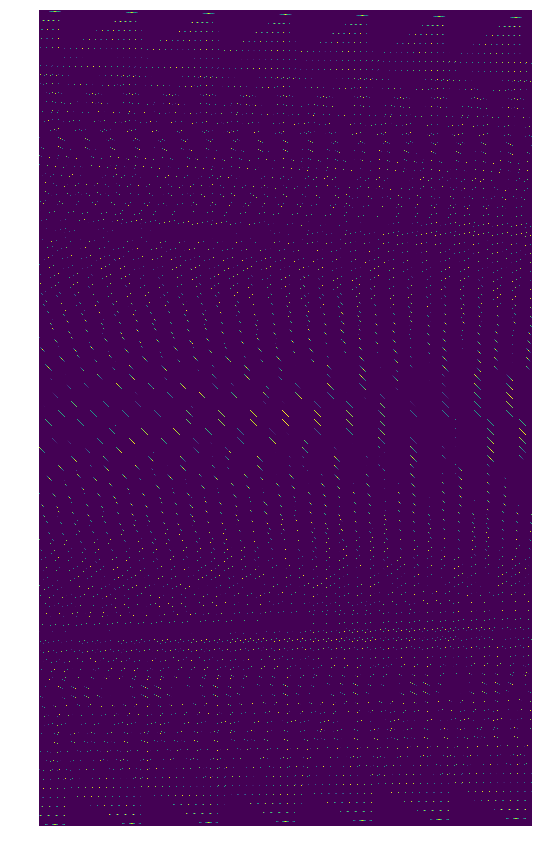

In [7]:
plt.figure(figsize=[10,15])
plt.imshow(X_77.toarray())
plt.axis('off')

In [8]:
# original versus provided solution error
np.sum((X_77.toarray()-X_77_sol.toarray())**2)

0.0

### Sparsity

In [9]:
print('non-zero entries:', X_195.nnz)
print('sparsity:', X_195.nnz*(X.shape[0]*X.shape[1])**-1)

non-zero entries: 13612950
sparsity: 3025.1000000000004


### Reconstruction

In [21]:
# small matrix
fitres = linalg.lsqr(A=X_77,b=y_77,atol=1e-5,btol=1e-5)
b = fitres[0]

(-0.5, 76.5, 76.5, -0.5)

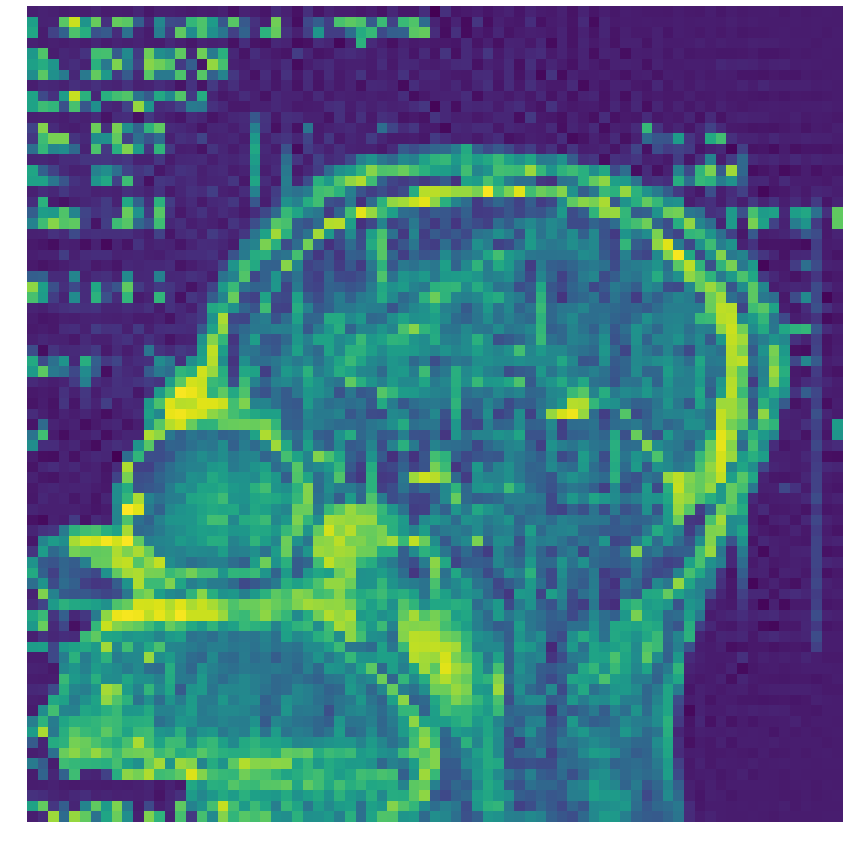

In [22]:
plt.figure(figsize=[15,15])
plt.imshow(b.reshape([77,77]))
plt.axis('off')

In [12]:
# large matrix

fitres = linalg.lsqr(A=X_195,b=y_195,atol=1e-5,btol=1e-5)
b_original = fitres[0]

(-0.5, 194.5, 194.5, -0.5)

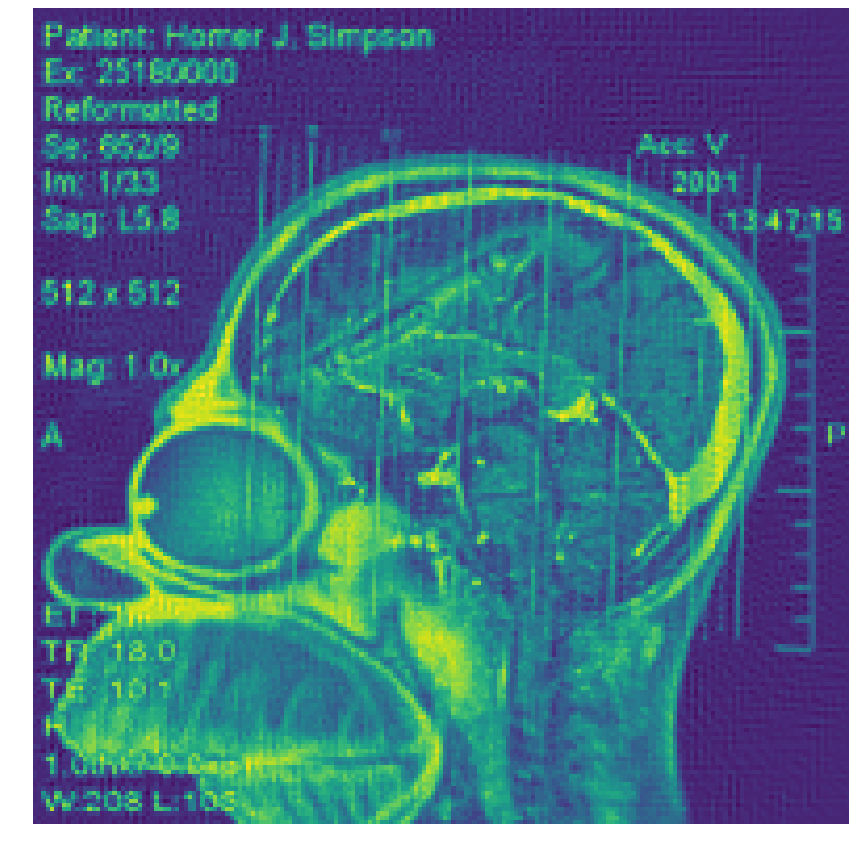

In [13]:
plt.figure(figsize=[15,15])
plt.imshow(np.rot90(b_original.reshape([195,195])))
plt.axis('off')

There is a pen in the head.

## 3 Minimizing the radiation dose

In [14]:
# display angles
alphas_195

array([-90, -89, -88, -87, -86, -85, -84, -83, -82, -81, -80, -79, -78,
       -77, -76, -75, -74, -73, -72, -71, -70, -69, -68, -67, -66, -65,
       -64, -63, -62, -61, -60, -59, -58, -57, -56, -55, -54, -53, -52,
       -51, -50, -49, -48, -47, -46, -45, -44, -43, -42, -41, -40, -39,
       -38, -37, -36, -35, -34, -33, -32, -31, -30, -29, -28, -27, -26,
       -25, -24, -23, -22, -21, -20, -19, -18, -17, -16, -15, -14, -13,
       -12, -11, -10,  -9,  -8,  -7,  -6,  -5,  -4,  -3,  -2,  -1,   0,
         1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,  13,
        14,  15,  16,  17,  18,  19,  20,  21,  22,  23,  24,  25,  26,
        27,  28,  29,  30,  31,  32,  33,  34,  35,  36,  37,  38,  39,
        40,  41,  42,  43,  44,  45,  46,  47,  48,  49,  50,  51,  52,
        53,  54,  55,  56,  57,  58,  59,  60,  61,  62,  63,  64,  65,
        66,  67,  68,  69,  70,  71,  72,  73,  74,  75,  76,  77,  78,
        79,  80,  81,  82,  83,  84,  85,  86,  87,  88], dtype=

First of all, the projections of configurations with angles separated by 180 degrees contain the same information. Thus, the data is already taken only in the range from -90 to 90 degrees. 

The maximum information difference is for angle differences of 90 degrees, because the projections are orthogonal in this case.

It makes thus sense to have equally spaced orthogonal projections. 

In [15]:
# chose 15 pairs of orthogonal projections
Na = 16
alphas_opt = np.array([np.linspace(-90,0,Na)[:-1],np.linspace(-90,0,Na)[:-1]+90]).ravel()
ind_opt = np.where([al in alphas_opt for al in alphas_195])[0]
alphas_opt

array([-90., -84., -78., -72., -66., -60., -54., -48., -42., -36., -30.,
       -24., -18., -12.,  -6.,   0.,   6.,  12.,  18.,  24.,  30.,  36.,
        42.,  48.,  54.,  60.,  66.,  72.,  78.,  84.])

(-0.5, 194.5, 194.5, -0.5)

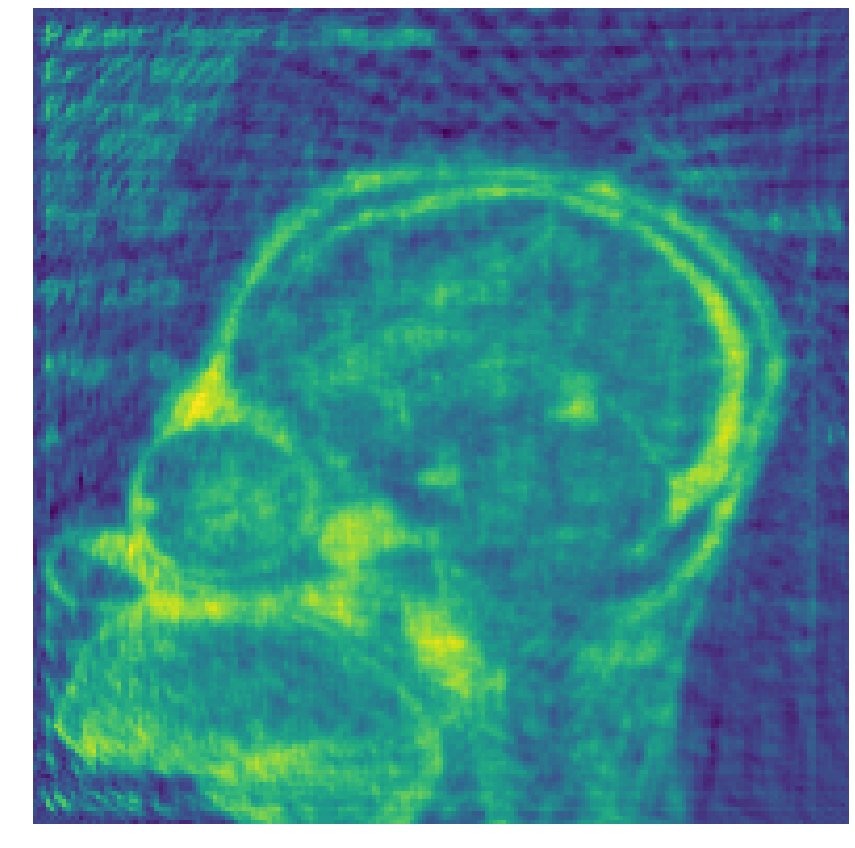

In [16]:
X_195_opt = construct_X(195,alphas_195[ind_opt],275,137,-97,-97)
y_195_opt = y_195.reshape([179,275])[ind_opt].ravel()
fitres = linalg.lsqr(A=X_195_opt,b=y_195_opt,atol=1e-5,btol=1e-5)
b = fitres[0]

plt.figure(figsize=[15,15])
plt.imshow(np.rot90(b.reshape([195,195])))
plt.axis('off')

15 pairs of orthogonal projections are not sufficient to well resolve the image. 

(-0.5, 194.5, 194.5, -0.5)

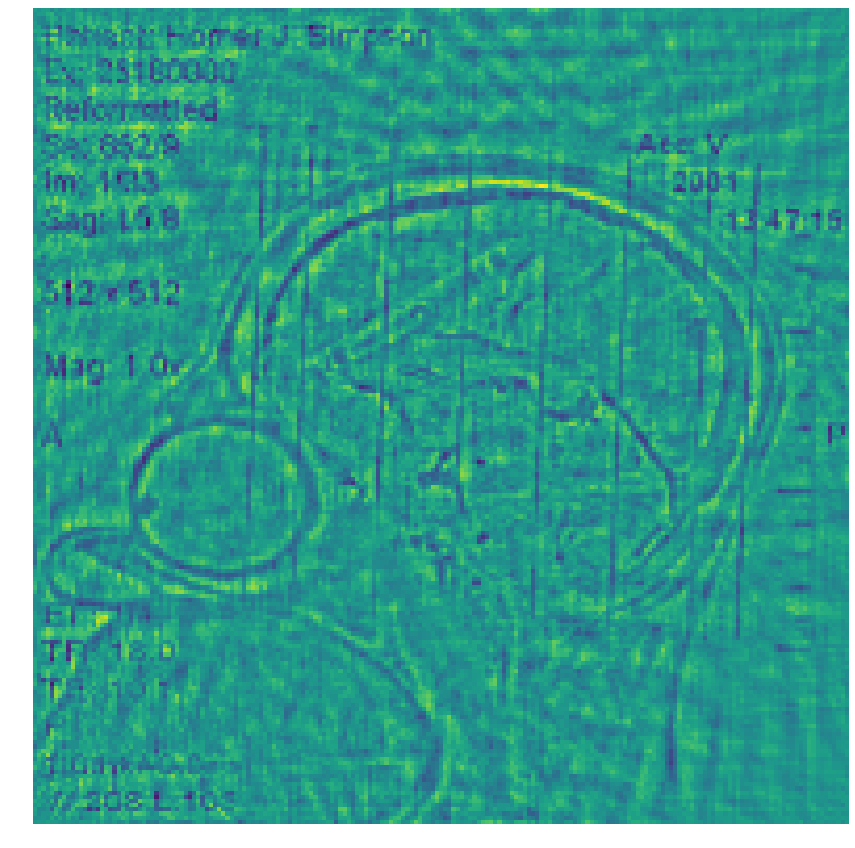

In [17]:
# show difference to original image

plt.figure(figsize=[15,15])
plt.imshow(np.rot90((b-b_original).reshape([195,195])))
plt.axis('off')

The difference image reveals stripe-shaped artifacts of the sparsely sampled reconstruction.

In [18]:
# chose 30 pairs of orthogonal projections
Na = 31

alphas_opt = np.array([np.linspace(-90,0,Na)[:-1],np.linspace(-90,0,Na)[:-1]+90]).ravel()
ind_opt = np.where([al in alphas_opt for al in alphas_195])[0]
alphas_opt

array([-90., -87., -84., -81., -78., -75., -72., -69., -66., -63., -60.,
       -57., -54., -51., -48., -45., -42., -39., -36., -33., -30., -27.,
       -24., -21., -18., -15., -12.,  -9.,  -6.,  -3.,   0.,   3.,   6.,
         9.,  12.,  15.,  18.,  21.,  24.,  27.,  30.,  33.,  36.,  39.,
        42.,  45.,  48.,  51.,  54.,  57.,  60.,  63.,  66.,  69.,  72.,
        75.,  78.,  81.,  84.,  87.])

(-0.5, 194.5, 194.5, -0.5)

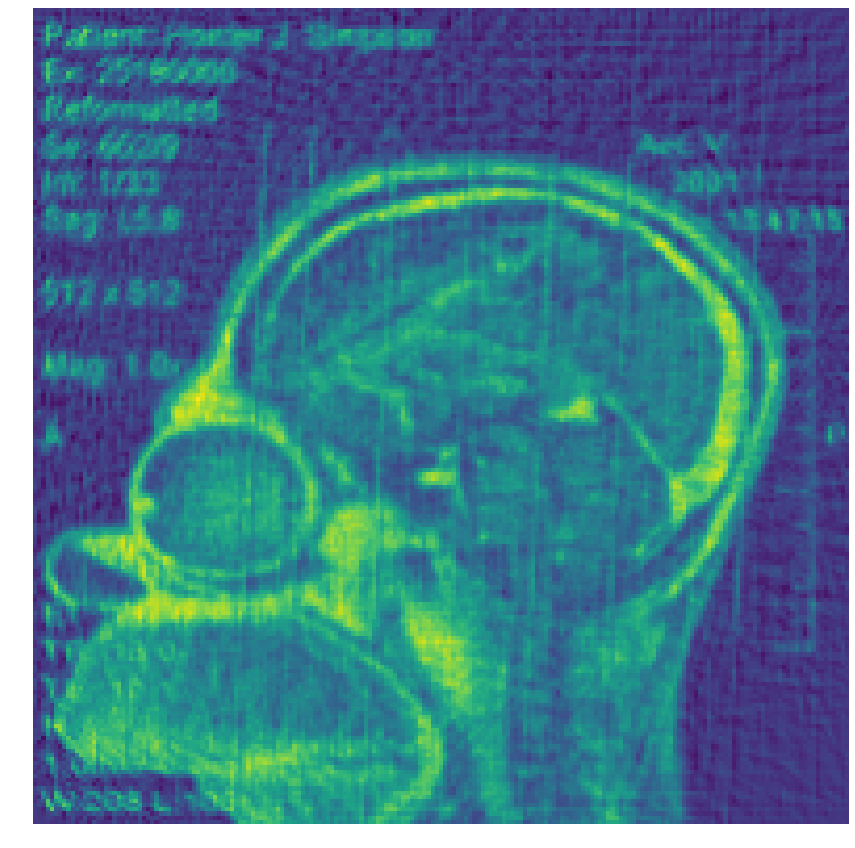

In [19]:
X_195_opt = construct_X(195,alphas_195[ind_opt],275,137,-97,-97)
y_195_opt = y_195.reshape([179,275])[ind_opt].ravel()
fitres = linalg.lsqr(A=X_195_opt,b=y_195_opt,atol=1e-5,btol=1e-5)
b = fitres[0]

plt.figure(figsize=[15,15])
plt.imshow(np.rot90(b.reshape([195,195])))
plt.axis('off')

30 pairs of orthogonal projections are sufficient to resolve the image well enough to detect the pen. Thus, our minimal number of projections is 60.